<a href="https://colab.research.google.com/github/brentkendrick/HPLC-Data-Analysis/blob/master/HPLC%20data%20normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %pip install peakutils  #needed for Google Colab and Microsoft Azure

In [2]:
# import modules

import pandas as pd
import numpy as np
import peakutils

from norbi.ui.plotly_plots import raw_data_graph, baseline_check_graph, peak_ctr_check_graph
from norbi.ui.static_plots import inset_plot
from norbi.ui.create_df import create_df
from norbi.normalize.df_norm import df_trunc, df_center, df_area_norm
from norbi.normalize.baseline import baseline_als, baseline_all

pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 8500)
%matplotlib inline

# Code start

In [3]:
df, metadata = create_df()

Enter 1 to import Agilent Chemstation file(s), 
                or 2 to import Excel data (will import first sheet in workbook): 2


# Create interactive graph to interrogate region of interest

In [4]:
df.head(3)

x-axis     rep 1     rep 2     rep 3     rep 4
0  0.000000  0.060681  0.095745  0.035863  0.057120
1  0.009707  0.060262  0.095500  0.035496  0.057297
2  0.019414  0.059723  0.095439  0.034824  0.057710

In [5]:
metadata

{1: {'Message': 'No metadata for xlsx files!'}}

In [6]:
pd.DataFrame(metadata).T

Message
1  No metadata for xlsx files!

In [7]:
raw_data_graph(df)

### Enter left and right x-ranges to truncate data to applicable region

In [8]:
left_cut = 12
right_cut = 43

df_trnc = df_trunc(df, left_cut, right_cut)

# Raw chromatograms

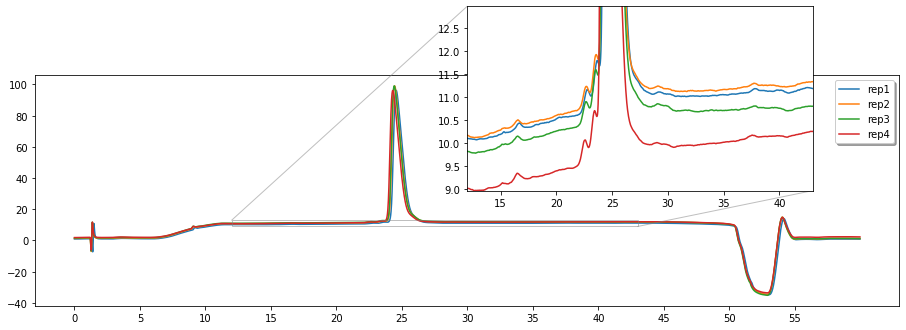

In [9]:
inset_plot(df, offint=0.3, x1=left_cut, x2=right_cut, y1=None, y2=None)

# Baseline correction algorithm 1
based on Eilers Asymmetric Least Squares Smoothing

There are two parameters: p for asymmetry and λ for smoothness. Both have to be tuned to the data at hand. 
For chemstation chromatograms, generally 1.0e-9 ≤ p ≤ 100.0e-9 is a good choice (for a signal with positive peaks) and 1.0e4 ≤ λ ≤ 100.0e4, but exceptions may occur. In any case one should vary λ on a grid that is approximately linear for log λ. Often visual inspection is sufficient to get good parameter values.

reference: https://stackoverflow.com/questions/29156532/python-baseline-correction-library/29185844


In [10]:
lam = 40.0e4 # larger than 5e6 causes concave down curvature, smaller causes upward
p = 30.0e-9 # larger than 10e-9 flattens bl around large peaks, smaller no impact

x_val = np.asarray(df_trnc.iloc[:,0])
y_val = np.asarray(df_trnc.iloc[:,1])

In [11]:
baseline = baseline_als(y_val, lam, p, niter=100)

In [12]:
baseline_check_graph(x_val, y_val, baseline, left_cut, right_cut, min_y=0, max_y=100)

In [13]:
df_baseline = baseline_all(df_trnc, lam, p, niter=100)

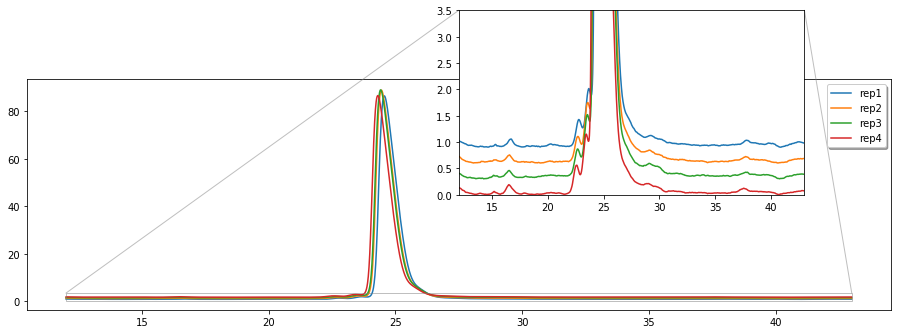

In [14]:
inset_plot(df_baseline, offint=0.3, x1=left_cut, x2=right_cut, y1=None, y2=3.5)

# Peak centering

In [15]:
x_val = np.asarray(df_baseline.iloc[:,0])
y_val = np.asarray(df_baseline.iloc[:,1])

# find peak center X, and Y values
ctr_indexes = peakutils.indexes(y_val, thres=.35, min_dist=1)

In [16]:
peak_ctr_check_graph(x_val, y_val, ctr_indexes, left_cut, right_cut, min_y=0, max_y=100)

In [17]:
df_ctr = df_center(df_baseline, ctr_indexes)

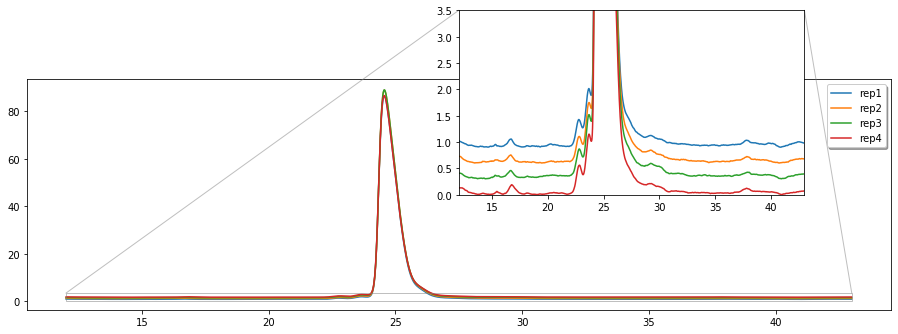

In [18]:
inset_plot(df_ctr, offint=0.3, x1=left_cut, x2=right_cut, y1=None, y2=3.5)

# Area normalize the data

In [19]:
df_area_normalized = df_area_norm(df_ctr)

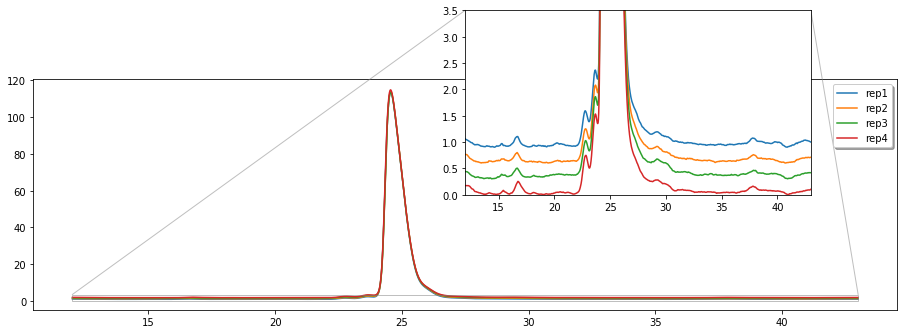

In [20]:
inset_plot(df_area_normalized, offint=0.3, x1=left_cut, x2=right_cut, y1=None, y2=3.5)